# Define Running Mode

- 'full_dataset = True' to use the full data set. If 'full_dataset = True', then a data set containing only data one year of the hobbies sales in TX2.  
    
- 'submit_to_kaggle = True' to submit the forecasts to Kaggle.  


In [1]:
full_dataset = False
submit_to_kaggle = False


# Import Packages

In [2]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle

# Data Import and Preparation

In [3]:
if full_dataset:
    prefix = 'full_dataset'
else:
    prefix = 'subset'
    
models_path = utils.get_m5_root_dir() + '/models/'

df_merged = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_df_merged.csv')

scaling_factors_rmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/scaling_factors_rmsse.csv')

weights_wrmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/weights_for_wrmsse.csv')


In [4]:
# downcast numerical values to reduce mem usage
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to 11.07 Mb (64.7% reduction)


# Delete Data where Item was not up for Sale

Item is not up for sale when price is NA.

In [5]:
print(df_merged.shape)

df_merged = df_merged.loc[df_merged['sell_price'] > 0]

print(df_merged.shape)

(120910, 34)
(120910, 34)


# Model Training & Forecasting (LightGBM)

In [6]:
# Custom Loss & valid for asymetric rmse
def custom_mse_asymmetric_loss(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.1)
    hess = np.where(residual < 0, 2, 2 * 1.1)
    return grad, hess


def custom_rmse_asymmetric_valid(y_pred, y_true, tmp=None):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2), (residual ** 2) * 1.1)
    return "custom_mse_asymmetric_eval", np.sqrt(np.mean(loss)), False

In [7]:
# TODO: proper feature selection (e.g. random forrest)
# for now: hardcoded list of features

cat_features = [
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id',
    'year',
    'month',
    'day',
    'is_weekend',
    'wday',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_CA',
    'snap_TX',
    'snap_WI',
    'up_for_sale'
]

num_features = [
    'sell_price',
    'lag_t28',
    'rolling_kurt_t28',
    'rolling_skew_t28',
    'rolling_mean_t28',
    'rolling_std_t28',
    'price_change_t1',
    'price_change_t30',
    'rolling_price_std_t28',
]

features = cat_features + num_features

In [8]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'seed': 10,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'feature_fraction ': 0.75,
    'num_leaves': 2^8,
}


In [9]:
for cat in df_merged.cat_id.drop_duplicates():
    for wday in df_merged.wday.drop_duplicates():

        print(f'\n ***** Computation for cat_id {cat} | wday {wday} *****')

        evals_result = {}
        start = time.time()

        print('log: create data sets')
        x_train = df_merged[df_merged['date'] <= '2016-03-27'].loc[
            df_merged['cat_id'] == cat].loc[
            df_merged['wday'] == wday][features]
        y_train = df_merged[df_merged['date'] <= '2016-03-27'].loc[
            df_merged['cat_id'] == cat].loc[
            df_merged['wday'] == wday]['sale']

        x_val = df_merged.loc[df_merged['data_type'] == 'train'].loc[
            df_merged['date'] > '2016-03-27'].loc[df_merged['cat_id'] ==
                                                  cat].loc[df_merged['wday'] ==
                                                  wday][features]
        y_val = df_merged.loc[df_merged['data_type'] == 'train'].loc[
            df_merged['date'] > '2016-03-27'].loc[df_merged['cat_id'] ==
                                                  cat].loc[df_merged['wday'] ==
                                                  wday]['sale']

        print('log: create LightGBM data sets')
        train_data = lgb.Dataset(
            x_train,
            label=y_train,
            categorical_feature=cat_features,
            free_raw_data=False,
        )
        validation_data = lgb.Dataset(
            x_val,
            label=y_val,
            categorical_feature=cat_features,
            free_raw_data=False,
            reference=train_data,
        )

        print('log: model training')
        gbm = lgb.train(params,
                        train_data,
                        valid_sets=[train_data, validation_data],
                        evals_result=evals_result,
                        num_boost_round=1000,
                        verbose_eval=25,
                        early_stopping_rounds=20,
                        fobj=custom_mse_asymmetric_loss,
                        feval=custom_rmse_asymmetric_valid)

        print('log: save model and evals result')
        gbm.save_model(f'{models_path}gbm_cat_id_{cat}_wday_{wday}_{prefix}.txt',
                       num_iteration=gbm.best_iteration)

        evals_result_p = open(
            f'{models_path}evals_result_cat_id_{cat}_wday_{wday}_{prefix}.pkl', 'wb')
        pickle.dump(evals_result, evals_result_p)
        evals_result_p.close()

        print('Training for cat_id %s | wday %s took %0.2f minutes.' %
              (cat, wday, (time.time() - start) / 60))


 ***** Computation for cat_id 0 | wday 6 *****
log: create data sets
log: create LightGBM data sets
log: model training
Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 1.30087	valid_1's custom_mse_asymmetric_eval: 1.70655
[50]	training's custom_mse_asymmetric_eval: 1.24082	valid_1's custom_mse_asymmetric_eval: 1.70224
Early stopping, best iteration is:
[40]	training's custom_mse_asymmetric_eval: 1.26379	valid_1's custom_mse_asymmetric_eval: 1.69317
log: save model and evals result
Training for cat_id 0 | wday 6 took 0.00 minutes.

 ***** Computation for cat_id 0 | wday 7 *****
log: create data sets


c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


log: create LightGBM data sets
log: model training
Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 1.26049	valid_1's custom_mse_asymmetric_eval: 1.25392
Early stopping, best iteration is:
[26]	training's custom_mse_asymmetric_eval: 1.25701	valid_1's custom_mse_asymmetric_eval: 1.2539
log: save model and evals result
Training for cat_id 0 | wday 7 took 0.00 minutes.

 ***** Computation for cat_id 0 | wday 1 *****
log: create data sets
log: create LightGBM data sets
log: model training
Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 1.41939	valid_1's custom_mse_asymmetric_eval: 1.39679
Early stopping, best iteration is:
[16]	training's custom_mse_asymmetric_eval: 1.46565	valid_1's custom_mse_asymmetric_eval: 1.38283
log: save model and evals result
Training for cat_id 0 | wday 1 took 0.00 minutes.

 ***** Computation for cat_id 0 | wday 2 *****
log: create data sets
log: crea

In [10]:
x_pred = df_merged[(df_merged['data_type'] == 'validation')][features]
x_pred['y_pred'] = np.nan

for cat in x_pred.cat_id.drop_duplicates():
    for wday in x_pred.wday.drop_duplicates():
        mod = lgb.Booster(
            model_file=f'{models_path}gbm_cat_id_{cat}_wday_{wday}_{prefix}.txt'
        )
        x_pred.loc[(x_pred.wday == wday) & (x_pred.cat_id == cat),'y_pred']= mod.predict(x_pred.loc[
                x_pred.cat_id == cat].loc[x_pred.wday == wday][features])
        

# Training Analysis


 ***** Computation for cat_id 0 | wday 3 *****


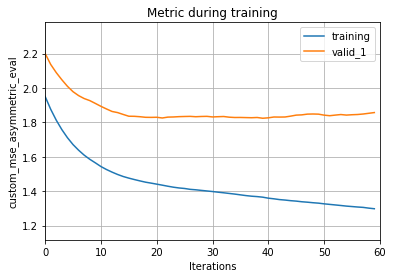

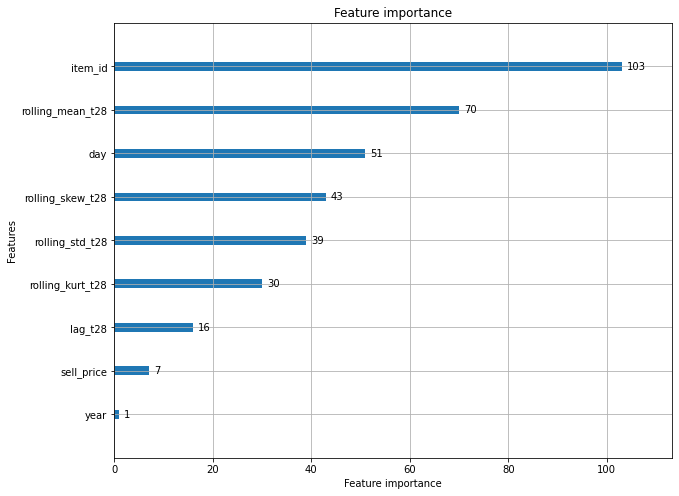


 ***** Computation for cat_id 0 | wday 4 *****


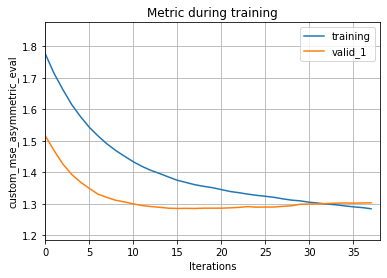

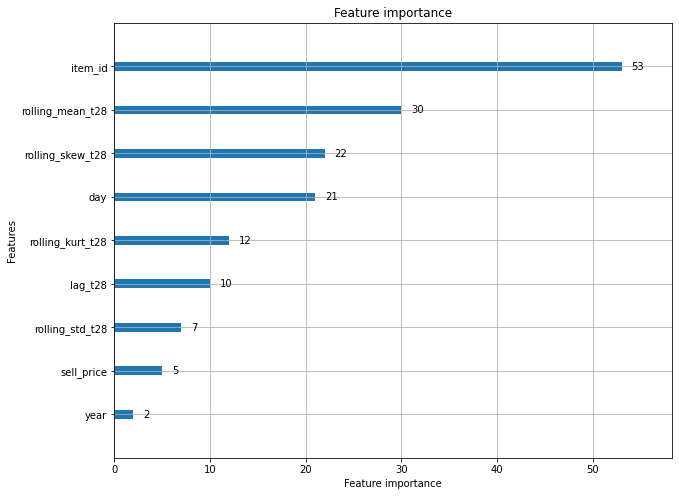


 ***** Computation for cat_id 0 | wday 5 *****


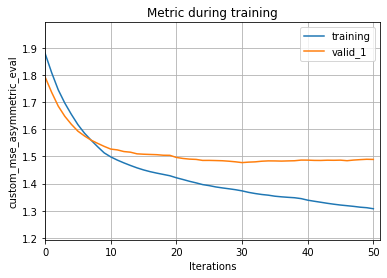

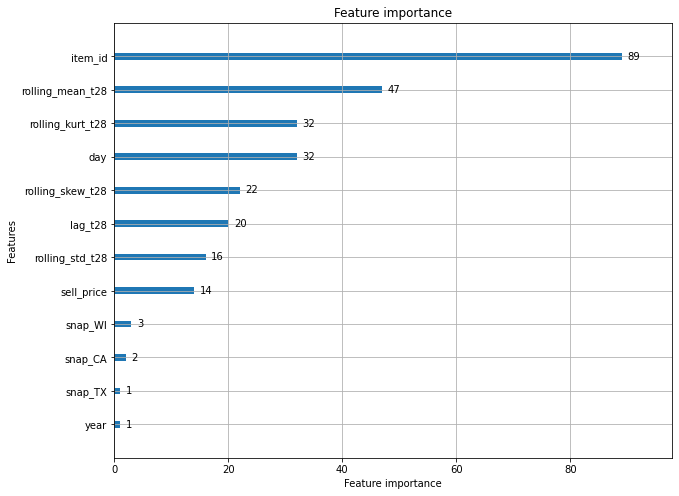


 ***** Computation for cat_id 0 | wday 6 *****


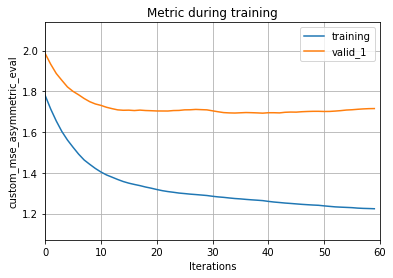

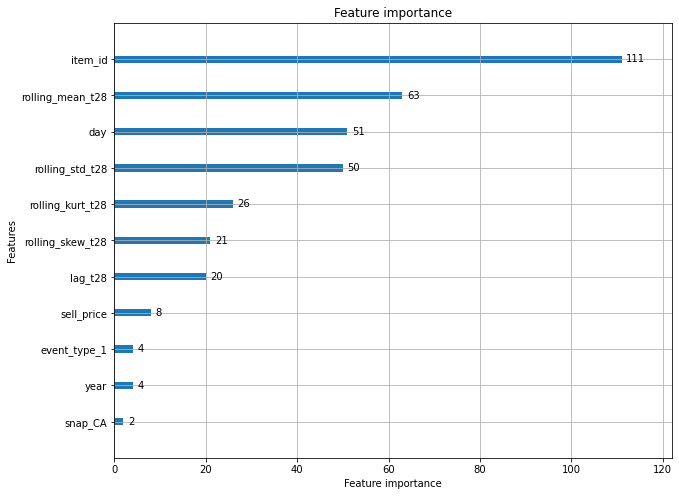


 ***** Computation for cat_id 0 | wday 7 *****


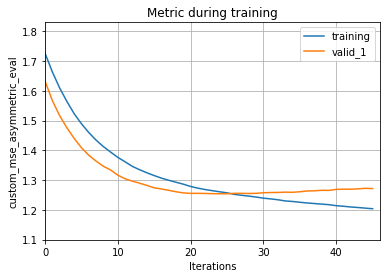

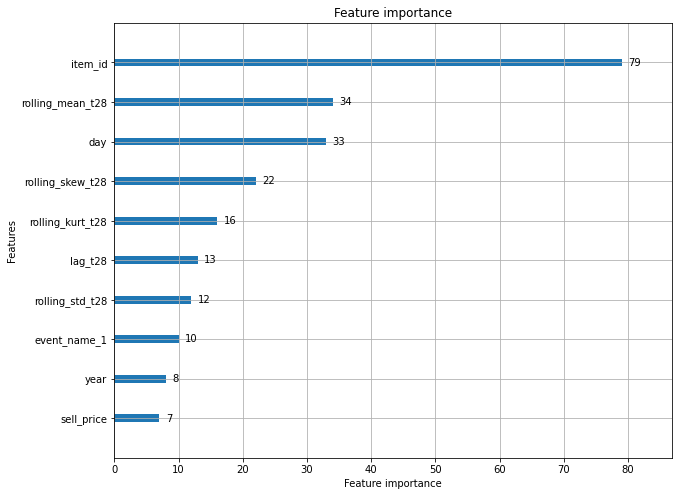


 ***** Computation for cat_id 0 | wday 1 *****


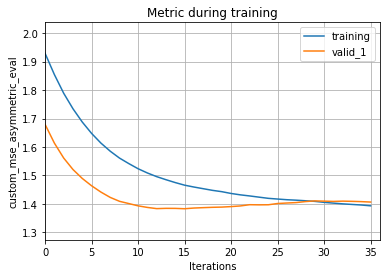

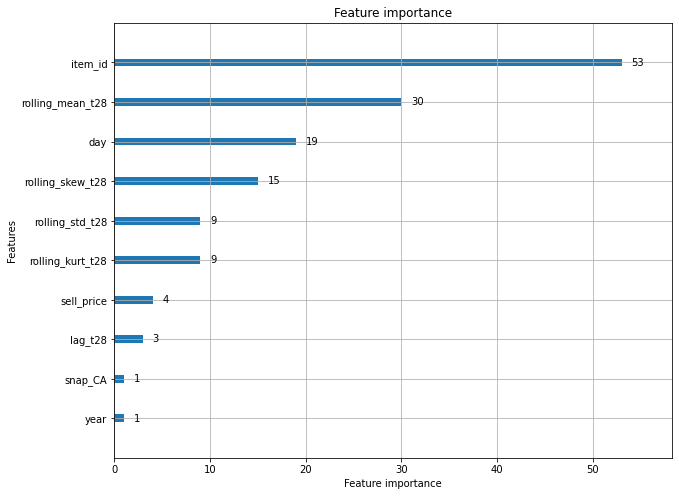


 ***** Computation for cat_id 0 | wday 2 *****


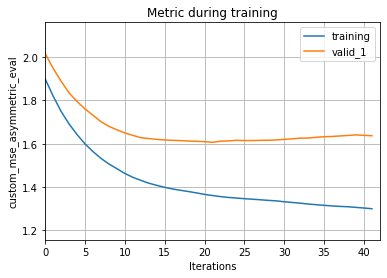

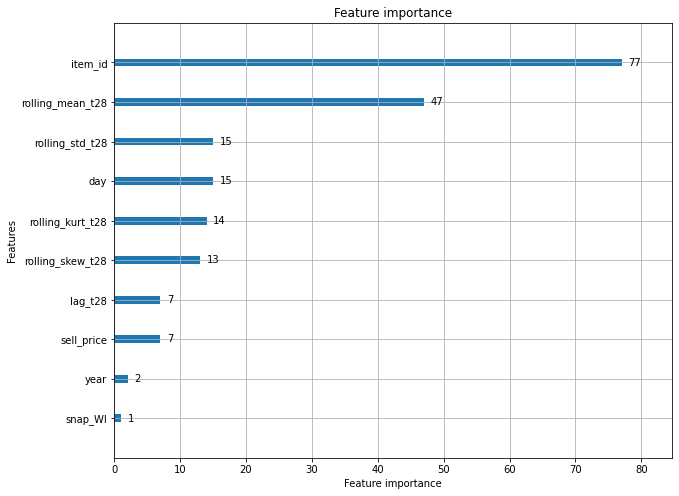

In [11]:
for cat in x_pred.cat_id.drop_duplicates():
    for wday in x_pred.wday.drop_duplicates():
        print(f'\n ***** Computation for cat_id {cat} | wday {wday} *****')

        mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_wday_{wday}_{prefix}.txt')
        evals = pickle.load(open(f'{models_path}evals_result_cat_id_{cat}_wday_{wday}_{prefix}.pkl', 'rb'))

        ax = lgb.plot_metric(evals)
        plt.show()

        ax = lgb.plot_importance(mod, figsize=(10,8))
        plt.show()

# Compute RMSSE and WRMSSE per Item on Validation Data

In [12]:
# compute forecasts, error and map it to df_merged to get ids
df_tmp = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27'][features].copy()
df_tmp['y_true'] = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27']['sale'].copy()

for cat in x_pred.cat_id.drop_duplicates():
    for wday in x_pred.wday.drop_duplicates():
        mod = lgb.Booster(
            model_file=f'{models_path}gbm_cat_id_{cat}_wday_{wday}_{prefix}.txt'
        )
        df_tmp.loc[(df_tmp.wday == wday) & (df_tmp.cat_id == cat),'y_pred']= mod.predict(df_tmp.loc[
                df_tmp.cat_id == cat].loc[df_tmp.wday == wday][features])
        
        
df_tmp['error'] = (df_tmp.y_true - df_tmp.y_pred)
df_tmp = df_tmp.merge(df_merged[['id', 'item_id','dept_id','cat_id', 'store_id', 'state_id']].drop_duplicates())

df_tmp.head(10)

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_true,y_pred,error,id
0,0,0,0,0,0,2016,3,28,0,3,...,3.823490,0.533333,1.166585,0.0,0.0,0.0,0.0,0.287891,-0.287891,HOBBIES_1_001_TX_2_validation
1,0,0,0,0,0,2016,3,29,0,4,...,4.239248,0.466667,1.136642,0.0,0.0,0.0,0.0,0.422326,-0.422326,HOBBIES_1_001_TX_2_validation
2,0,0,0,0,0,2016,3,30,0,5,...,4.239248,0.466667,1.136642,0.0,0.0,0.0,0.0,0.521423,-0.521423,HOBBIES_1_001_TX_2_validation
3,0,0,0,0,0,2016,3,31,0,6,...,4.239248,0.466667,1.136642,0.0,0.0,0.0,1.0,0.478223,0.521777,HOBBIES_1_001_TX_2_validation
4,0,0,0,0,0,2016,4,1,0,7,...,4.239248,0.466667,1.136642,0.0,0.0,0.0,0.0,0.371311,-0.371311,HOBBIES_1_001_TX_2_validation
5,0,0,0,0,0,2016,4,2,1,1,...,4.344295,0.433333,1.135124,0.0,0.0,0.0,2.0,0.387991,1.612009,HOBBIES_1_001_TX_2_validation
6,0,0,0,0,0,2016,4,3,1,2,...,1.111663,0.266667,0.449776,0.0,0.0,0.0,0.0,0.313235,-0.313235,HOBBIES_1_001_TX_2_validation
7,0,0,0,0,0,2016,4,4,0,3,...,1.111663,0.266667,0.449776,0.0,0.0,0.0,0.0,0.194372,-0.194372,HOBBIES_1_001_TX_2_validation
8,0,0,0,0,0,2016,4,5,0,4,...,1.111663,0.266667,0.449776,0.0,0.0,0.0,1.0,0.216153,0.783847,HOBBIES_1_001_TX_2_validation
9,0,0,0,0,0,2016,4,6,0,5,...,1.328338,0.233333,0.430183,0.0,0.0,0.0,0.0,0.369507,-0.369507,HOBBIES_1_001_TX_2_validation


In [13]:
# compute RMSSE and store it in dict
rmsse_dict = {}

for name, group in df_tmp.groupby(['id']):
    
    scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
    weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]
    
    rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
    

In [14]:
# convert dict to dataframe
rmsse_df = pd.DataFrame(rmsse_dict).T
rmsse_df['id'] = rmsse_df.index
rmsse_df = rmsse_df.reset_index(drop=True)
rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

# add weights to df and compute weights multiplied by RMSSE
rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

# sort values by their impact
rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)


In [15]:
# compute WRMSSE
print('WRMSSE = %0.5f' % np.sum(rmsse_df.RMSSE * rmsse_df.weights))
# WRMSSE = 0.01167

WRMSSE = 0.01196


In [16]:
# show RMSSE and corresponding weights
rmsse_df.sort_values(by='RMSSE', ascending=False).head(20)

,RMSSE,id,weights,w_times_RMSSE
522,2.151436,HOBBIES_2_107_TX_2_validation,0.000005,0.000010
197,1.944182,HOBBIES_1_204_TX_2_validation,0.000280,0.000545
176,1.884367,HOBBIES_1_181_TX_2_validation,0.000004,0.000008
556,1.821970,HOBBIES_2_141_TX_2_validation,0.000002,0.000003
251,1.494813,HOBBIES_1_259_TX_2_validation,0.000008,0.000011
180,1.470038,HOBBIES_1_186_TX_2_validation,0.000051,0.000075
392,1.466465,HOBBIES_1_401_TX_2_validation,0.000006,0.000008
47,1.463974,HOBBIES_1_048_TX_2_validation,0.000022,0.000032
447,1.451959,HOBBIES_2_032_TX_2_validation,0.000010,0.000014
101,1.431661,HOBBIES_1_106_TX_2_validation,0.000008,0.000011


In [17]:
# analyse time series (manually)
rel_id = 'FOODS_3_618_TX_2_validation'
df_tmp.loc[df_tmp.id == rel_id][[
    'id',
    'month',
    'day',
    'up_for_sale',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'is_weekend',
    'wday',
    'sell_price',
    'y_pred',
    'y_true',
    'error',
]]

,id,month,day,up_for_sale,event_name_1,event_type_1,event_name_2,event_type_2,is_weekend,wday,sell_price,y_pred,y_true,error


# Compute RMSSE and WRMSSE per Forecast Horizon on Validation Data

In [18]:
tmp = df_tmp[['id', 'year', 'month', 'day', 'y_pred', 'y_true', 'error']]
tmp_grouped = tmp.groupby(['year', 'month', 'day'])


for date, row in tmp_grouped:
    
    # compute RMSSE and store it in dict
    rmsse_dict = {}

    for name, group in row.groupby(['id']):

        scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
        weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]

        rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
        
        
    # convert dict to dataframe
    rmsse_df = pd.DataFrame(rmsse_dict).T
    rmsse_df['id'] = rmsse_df.index
    rmsse_df = rmsse_df.reset_index(drop=True)
    rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

    # add weights to df and compute weights multiplied by RMSSE
    rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
    rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

    # sort values by their impact
    rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)

    print('WRMSSE of %s = %0.5f' % (date, np.sum(rmsse_df.RMSSE * rmsse_df.weights)))
    # WRMSSE overall = 0.01167

    
    


WRMSSE of (2016, 3, 28) = 0.00825
WRMSSE of (2016, 3, 29) = 0.00678
WRMSSE of (2016, 3, 30) = 0.00914
WRMSSE of (2016, 3, 31) = 0.00782
WRMSSE of (2016, 4, 1) = 0.00981
WRMSSE of (2016, 4, 2) = 0.00937
WRMSSE of (2016, 4, 3) = 0.00958
WRMSSE of (2016, 4, 4) = 0.00807
WRMSSE of (2016, 4, 5) = 0.00909
WRMSSE of (2016, 4, 6) = 0.00869
WRMSSE of (2016, 4, 7) = 0.00913
WRMSSE of (2016, 4, 8) = 0.00795
WRMSSE of (2016, 4, 9) = 0.01073
WRMSSE of (2016, 4, 10) = 0.01174
WRMSSE of (2016, 4, 11) = 0.01081
WRMSSE of (2016, 4, 12) = 0.00986
WRMSSE of (2016, 4, 13) = 0.00957
WRMSSE of (2016, 4, 14) = 0.00840
WRMSSE of (2016, 4, 15) = 0.00779
WRMSSE of (2016, 4, 16) = 0.00960
WRMSSE of (2016, 4, 17) = 0.01149
WRMSSE of (2016, 4, 18) = 0.00978
WRMSSE of (2016, 4, 19) = 0.00945
WRMSSE of (2016, 4, 20) = 0.01161
WRMSSE of (2016, 4, 21) = 0.01045
WRMSSE of (2016, 4, 22) = 0.00907
WRMSSE of (2016, 4, 23) = 0.01018
WRMSSE of (2016, 4, 24) = 0.00930


# Printout Forecasts

In [19]:
x_pred

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,sell_price,lag_t28,rolling_kurt_t28,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred
105090,0,0,0,0,0,2016,4,25,0,3,...,8.26,0.0,8.085505,2.942952,0.266667,0.691492,0.0,0.0,0.0,0.195820
105091,1,0,0,0,0,2016,4,25,0,3,...,3.97,0.0,28.000000,5.477226,0.033333,0.182574,0.0,0.0,0.0,0.153902
105092,2,0,0,0,0,2016,4,25,0,3,...,2.97,0.0,28.000000,5.477226,0.033333,0.182574,0.0,0.0,0.0,0.152960
105093,3,0,0,0,0,2016,4,25,0,3,...,4.64,0.0,0.815230,1.051023,1.100000,1.322224,0.0,0.0,0.0,0.768066
105094,4,0,0,0,0,2016,4,25,0,3,...,2.73,0.0,6.833795,2.557249,0.600000,1.132589,0.0,0.0,0.0,0.515117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120905,560,1,0,0,0,2016,5,22,1,2,...,2.88,0.0,11.497869,3.494974,0.133333,0.434172,0.0,0.0,0.0,0.240422
120906,561,1,0,0,0,2016,5,22,1,2,...,1.97,2.0,3.233676,2.147972,0.266667,0.583292,0.0,0.0,0.0,0.276961
120907,562,1,0,0,0,2016,5,22,1,2,...,0.97,0.0,6.534278,2.387013,0.700000,1.118805,0.0,0.0,0.0,0.432709
120908,563,1,0,0,0,2016,5,22,1,2,...,0.88,0.0,NaN,NaN,0.000000,0.000000,0.0,0.0,0.0,0.240422


In [20]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'year', 'month', 'day','store_id']].drop_duplicates()
df_results = x_pred.merge(id_mapping_table,
                         on=['item_id', 'store_id', 'year', 'month', 'day'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [21]:
id_mapping_table

,id,item_id,year,month,day,store_id
0,HOBBIES_1_001_TX_2_validation,0,2015,10,22,0
1,HOBBIES_1_002_TX_2_validation,1,2015,10,22,0
2,HOBBIES_1_003_TX_2_validation,2,2015,10,22,0
3,HOBBIES_1_004_TX_2_validation,3,2015,10,22,0
4,HOBBIES_1_005_TX_2_validation,4,2015,10,22,0
...,...,...,...,...,...,...
120905,HOBBIES_2_145_TX_2_validation,560,2016,5,22,0
120906,HOBBIES_2_146_TX_2_validation,561,2016,5,22,0
120907,HOBBIES_2_147_TX_2_validation,562,2016,5,22,0
120908,HOBBIES_2_148_TX_2_validation,563,2016,5,22,0


In [22]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [23]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df = submission_df.clip(lower=0) # Convert negative values to 0
submission_df.reset_index(level=0, inplace=True)
f_list = [f'F{di}' for di in list(range(1, 29))]
submission_df.columns = ['id'] + f_list
submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_TX_2_validation,0.195820,0.216153,0.414684,0.500557,0.574176,0.363754,0.441996,0.287891,0.278500,...,0.304439,0.363754,0.441996,0.287891,0.278500,0.521259,0.602044,0.857666,0.308775,0.441996
1,HOBBIES_1_002_TX_2_validation,0.153902,0.178652,0.220175,0.200202,0.222331,0.221919,0.240422,0.153902,0.178652,...,0.222331,0.221919,0.240422,0.153902,0.178652,0.220175,0.215259,0.222331,0.221919,0.276961
2,HOBBIES_1_003_TX_2_validation,0.152960,0.178652,0.220175,0.149619,0.222331,0.221919,0.240422,0.152960,0.178652,...,0.222331,0.221919,0.240422,0.152960,0.178652,0.220175,0.149619,0.222331,0.221919,0.240422
3,HOBBIES_1_004_TX_2_validation,0.768066,0.575505,0.595087,0.656710,0.877055,0.813144,1.058786,0.783095,0.575505,...,0.704021,0.916870,1.165349,0.783095,0.575505,0.613113,0.604957,0.913917,0.748081,1.165349
4,HOBBIES_1_005_TX_2_validation,0.515117,0.651424,0.416955,0.682552,0.839518,0.584233,0.503988,0.515117,0.651424,...,0.839518,0.584233,0.503988,0.362187,0.537899,0.396522,0.471416,0.753763,0.559995,0.395480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,HOBBIES_2_145_TX_2_validation,0.362187,0.216153,0.239427,0.264121,0.240069,0.308775,0.324200,0.267050,0.216153,...,0.222331,0.221919,0.276961,0.212610,0.178652,0.220175,0.227765,0.222331,0.221919,0.240422
561,HOBBIES_2_146_TX_2_validation,0.345710,0.216153,0.266445,0.304772,0.308848,0.363754,0.432709,0.360739,0.278500,...,0.240069,0.221919,0.276961,0.212610,0.178652,0.220175,0.227765,0.240069,0.221919,0.276961
562,HOBBIES_2_147_TX_2_validation,0.515117,0.389723,0.416955,0.441343,0.375720,0.387991,0.432709,0.515117,0.422286,...,0.375720,0.436860,0.608537,0.556135,0.575505,0.510061,0.441343,0.375720,0.436860,0.432709
563,HOBBIES_2_148_TX_2_validation,0.212610,0.178652,0.220175,0.227765,0.222331,0.221919,0.240422,0.212610,0.178652,...,0.222331,0.221919,0.240422,0.212610,0.178652,0.220175,0.227765,0.222331,0.221919,0.240422


# Increase Predictions for Food Items as they are underestimated

In [24]:
"""
food_list = []
for i in rmsse_df.head(50).itertuples():
    if 'FOODS' in i.id:
        food_list.append(i.id)
"""



"\nfood_list = []\nfor i in rmsse_df.head(50).itertuples():\n    if 'FOODS' in i.id:\n        food_list.append(i.id)\n"

In [25]:

"""

submission_df.loc[submission_df.id.isin(food_list),
                  f_list] = submission_df.loc[submission_df.id.isin(food_list),
                                            f_list] * 1.4

submission_df
"""



'\n\nsubmission_df.loc[submission_df.id.isin(food_list),\n                  f_list] = submission_df.loc[submission_df.id.isin(food_list),\n                                            f_list] * 1.4\n\nsubmission_df\n'

# Submit to Kaggle 

In [26]:
df_submission = submission_df.append(
    submission_df.replace(to_replace='validation',
                          value='evaluation',
                          regex=True))
filename = utils.get_m5_root_dir(
) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
df_submission.to_csv(filename, index=False)